In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder
from typing import Annotated, List, Tuple, Union

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END
import torch 
from langchain_experimental.tools import PythonREPLTool

load_dotenv()

True

In [2]:
os.environ['OPENAI_API_KEY'] = os.environ.get("OPENAI_API_KEY")
os.environ['TAVILY_API_KEY'] = os.environ.get("TAVILY_API_KEY")

In [3]:

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, streaming=True)

### Create Agent function

In [4]:
def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

# Creación de herramientas 
- Tavily Search tool
- PythonREPLTool

In [5]:
tavily_tool = TavilySearchResults(max_results=5)

In [6]:
python_repl_tool = PythonREPLTool()

### RAG Setup with vector DB

In [7]:
loader = DirectoryLoader('./source', glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()

In [8]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
# doc_strings = [doc.page_content for doc in new_docs]

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': device}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)
embeddings.__dict__

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

d:\Proyecto_holagrama_IA\LanGraph\v2email\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'client': SentenceTransformer(
   (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
   (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
   (2): Normalize()
 ),
 'model_name': 'sentence-transformers/all-mpnet-base-v2',
 'cache_folder': None,
 'model_kwargs': {'device': 'cpu'},
 'encode_kwargs': {'normalize_embeddings': True},
 'multi_process': False,
 'show_progress': False}

In [10]:
db = Chroma.from_documents(new_docs, embeddings)


In [11]:
retriever = db.as_retriever(search_kwargs={"k": 4})


### RAG Tool : Python function -> tool

In [12]:
@tool
def RAG(state):

    """Utilícelo para ejecutar el RAG. Si la pregunta está relacionada con Japón o Deportes, utilice esta herramienta para obtener los resultados."""

    print('-> Calling RAG ->')
    question = state
    print('Question:',question)

    template = """Responda a la pregunta basándose únicamente en el siguiente contexto:
    {context}

    Pregunta: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

### Agent node 
 - toma estado , agente y nombre como entrada 
 - devolver mesage como HumanMessage con nombre

In [13]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Supervisor Chain creation 

El supervisor de nuestro equipo es un nodo LLM. Se limita a elegir el siguiente agente a procesar y decide cuándo se ha completado el trabajo

- Tiene acceso e información sobre sus miembros. 
- members = ["RAG" , "Researcher", "Coder"]
- options = ["FINISH"] + members
- "Dada la conversación anterior, ¿quién debería actuar a continuación?"
   " ¿O hay que ACABAR? Seleccione una de las siguientes opciones: {options}"

- Router -> function_def

In [14]:
members = ["RAG" , "Researcher", "Coder"]
options = ["FINISH"] + members
options


['FINISH', 'RAG', 'Researcher', 'Coder']

In [15]:

system_prompt = (
    """Eres un supervisor encargado de gestionar una conversación entre los siguientes trabajadores:  {members}. Dada la siguiente petición del usuario, responda con el trabajador que debe actuar a continuación. Utilice la herramienta RAG cuando las preguntas estén relacionadas con Japón o de categoría Deportes. Cada trabajador realizará una tarea y responderá con sus resultados y estado. Cuando termine, responde con FINISH."""
)

In [16]:
# El uso de llamadas a funciones openai puede facilitarnos el análisis sintáctico de la salida
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}

In [17]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Dada la conversación anterior, ¿quién debe actuar a continuación? ¿O debemos TERMINAR? Seleccione una de: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


In [18]:
supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)


### Creation of workflow with below nodes 

Agent ->> Node (functools.partial)

 - Research Node
 - Code Node
 - RAG Node

In [19]:
class AgentState(TypedDict):
    # La anotación indica al gráfico que siempre se añadirán nuevos mensajes a los estados actuales
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # El campo «next» indica el siguiente destino
    next: str

In [20]:
research_agent = create_agent(
    llm, 
    [tavily_tool], 
    "Usted es investigador web."
    )
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

In [21]:

# NOTE: ESTO REALIZA LA EJECUCIÓN DE CÓDIGO ARBITRARIO. PROCEDA CON PRECAUCIÓN
code_agent = create_agent(
    llm,
    [python_repl_tool],
    "Puedes generar código python seguro para analizar datos y generar gráficos utilizando matplotlib.",
)
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

In [22]:
RAG_agent = create_agent(
    llm,
    [RAG],
    "Utilice estas herramientas cuando las preguntas estén relacionadas con Japón o de la categoría Deportes..",
)
rag_node = functools.partial(agent_node, agent=RAG_agent, name="RAG")

In [23]:
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("RAG", rag_node)
workflow.add_node("supervisor", supervisor_chain)

In [24]:
members

['RAG', 'Researcher', 'Coder']

### Creation of edges

In [25]:
for member in members:
    # Queremos que nuestros trabajadores SIEMPRE «informen» al supervisor cuando hayan terminado.
    workflow.add_edge(member, "supervisor")
# El supervisor rellena el campo «siguiente» en el estado del grafo que dirige a un nodo o termina
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

In [26]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Codifica hola mundo e imprímelo en el terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Coder'}}
----


Python REPL can execute arbitrary code. Use with caution.


{'Coder': {'messages': [HumanMessage(content='Se imprimió "Hola Mundo" en el terminal. ¿Hay algo más en lo que pueda ayudarte?', name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [27]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="En que ayuda el deporte a la salud?")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'RAG'}}
----
-> Calling RAG ->
Question: Deportes
{'RAG': {'messages': [HumanMessage(content='El deporte ayuda a la salud de diversas maneras, incluyendo:\n\n1. Mejora la salud cardiovascular: El ejercicio físico regular fortalece el corazón y mejora la circulación sanguínea, reduciendo el riesgo de enfermedades cardíacas.\n\n2. Control del peso: El deporte ayuda a quemar calorías y mantener un peso saludable, lo que a su vez reduce el riesgo de obesidad y enfermedades relacionadas.\n\n3. Fortalecimiento muscular y óseo: La actividad física fortalece los músculos y los huesos, previniendo la pérdida de masa muscular y la osteoporosis.\n\n4. Mejora la salud mental: El deporte libera endorfinas, conocidas como las "hormonas de la felicidad", que ayudan a reducir el estrés, la ansiedad y la depresión.\n\n5. Mejora la calidad del sueño: El ejercicio regular puede mejorar la calidad del sueño y ayudar a combatir el insomnio.\n\nEn resumen, el deporte es una herramien

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='Se ha encontrado información sobre el crecimiento del PIB de la India en los últimos años. A continuación, procederé a graficar esta información.\nPara graficar el crecimiento del PIB de la India en los últimos años, necesitaré un momento para codificar el gráfico lineal en Python. Por favor, espere un momento.', name='Researcher')]}}
----
{'supervisor': {'next': 'Coder'}}
----


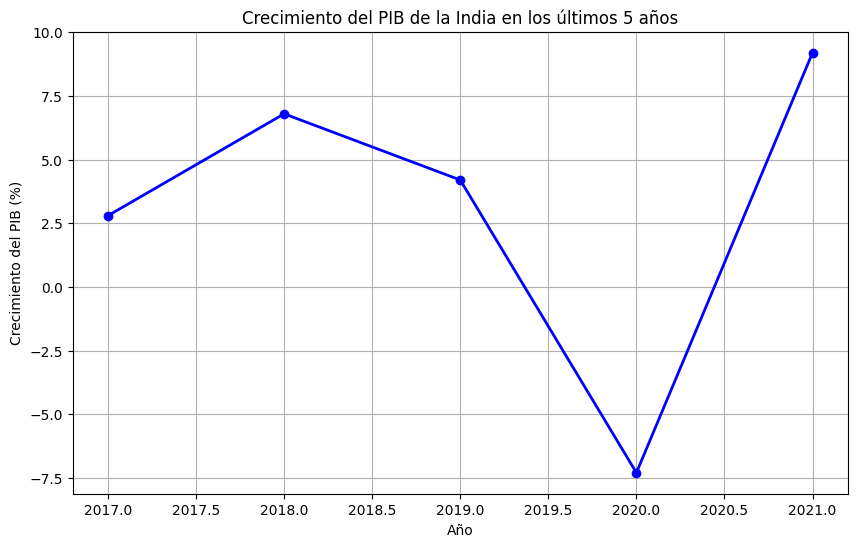

{'Coder': {'messages': [HumanMessage(content='Se ha generado el gráfico lineal que muestra el crecimiento del PIB de la India en los últimos 5 años. Puedes ver el gráfico arriba.\n\n- El eje x representa los años (2017, 2018, 2019, 2020, 2021).\n- El eje y representa el crecimiento del PIB en porcentaje (%).\n\nSi necesitas más análisis o gráficos, ¡házmelo saber!', name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [28]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="""Sigue los siguientes pasos:
                        1- Obtén el PIB de la India en los últimos 5 años usando la herramienta di search.
                        2- dibuja un gráfico lineal del mismo usando la herramienta de codigo de python.
                        3- Una vez que lo codifiques, termina.""")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

### Supervisor --> RAG -> Data ->> Python --> Run --> Visualization

{'supervisor': {'next': 'RAG'}}
----
-> Calling RAG ->
Question: PIB de Japón en los últimos 4 años
-> Calling RAG ->
Question: Dibujar un gráfico lineal del PIB de Japón en los últimos 4 años
{'RAG': {'messages': [HumanMessage(content='El PIB de Japón en los últimos 4 años ha mostrado un crecimiento constante, con un aumento del 1,6% en 2022, signos de recuperación en 2021 y un crecimiento del 0,4% en el primer trimestre de 2023. Lamentablemente, no puedo dibujar un gráfico lineal. ¿Hay algo más en lo que pueda ayudarte?', name='RAG')]}}
----
{'supervisor': {'next': 'Coder'}}
----


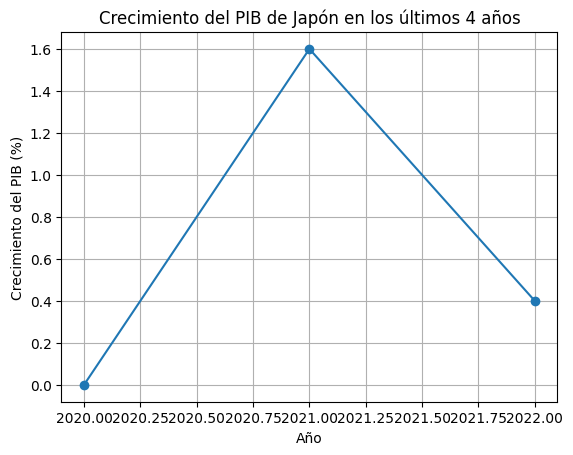

{'Coder': {'messages': [HumanMessage(content='Aquí tienes el gráfico lineal que muestra el crecimiento del PIB de Japón en los últimos 4 años. Como mencionaste que en 2021 hubo signos de recuperación y no un valor específico, se ha representado de esa manera en el gráfico.\n\nSi necesitas ayuda adicional, ¡no dudes en decírmelo!', name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [29]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="""Obtén el PIB de Japón en los últimos 4 años de RAG,»
                « y luego dibuja un gráfico lineal del mismo.»
                « Una vez que lo codifiques, termina.""")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")